In [1]:
# set up
!pip install git+https://github.com/dicarlolab/CORnet     # download cornet
    
import cornet
import torch 
import matplotlib.pyplot as plt
import itertools
from scipy import signal

CN_Z = cornet.get_model('z',pretrained=True);

# get CUDA index
DEVICE = torch.cuda.current_device()


  Cloning https://github.com/dicarlolab/CORnet to /tmp/pip-req-build-hmhwza75
  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet /tmp/pip-req-build-hmhwza75
  Resolved https://github.com/dicarlolab/CORnet to commit 4a0e8e408a45729c8e560d8704761c5172ce3017
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 967.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23247 sha256=4485552a5398a160afc796bab0267f4a2bc568c7b02fa47713f19e9e2b29e9d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-cccri_yi/wheels/60/a5/05/a6b9a1229c3917325451416816ac5eec8b7e8c1f13d1dc7370
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=a9f9fe629494577a1a5471224daf2b5586d474d538f66b2d7b97f01be867390e
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c6498122

Downloading: "https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth" to /root/.cache/torch/hub/checkpoints/cornet_z-5c427c9c.pth


  0%|          | 0.00/15.8M [00:00<?, ?B/s]

In [2]:
# plotting settings

import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)


In [3]:
# freeze pre-trained parameters

# look at children
child_counter = 0
for child in CN_Z.module.children():
    #print(" child", child_counter, "is -")
    #print(child)
    child_counter += 1
    
# freeze children
freeze_child_counter = 0
for child in CN_Z.module.children():
    if freeze_child_counter < child_counter-1:
        print("child ",freeze_child_counter," was frozen")
        for param in child.parameters():
            param.requires_grad = False
        
        freeze_child_counter += 1   

# copy CN_Z module except for second to last layer
CN_Z_AET = CN_Z.module[:-1]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was frozen


In [4]:
# add fully connected and decoder layer
size_hid = 64

from collections import OrderedDict

fc_lay = torch.nn.Sequential(OrderedDict([
            ('avgpool', torch.nn.AdaptiveAvgPool2d(1)),
            ('flatten', torch.nn.Flatten(start_dim=0)),
            ('linear', torch.nn.Linear(512, size_hid)),
            ('nonlin', torch.nn.Sigmoid())])).to(DEVICE)

decoder = torch.nn.Sequential(OrderedDict([
            ('linear', torch.nn.Linear(size_hid,4)),
            ('nonlin', torch.nn.Sigmoid())])).to(DEVICE)

CN_Z_AET.add_module('fc',fc_lay)
CN_Z_AET.add_module('decoder',decoder)
CN_Z.module = CN_Z_AET

In [5]:
## FUNCTIONS

# create A,E,T,Z stimuli
# change to size 224x224

def mkstim(noise_=False):
    # create stimuli
    A = torch.zeros((112,112))
    A[20:40,40:80] = 1
    A[65:85,40:80] = 1
    A[20:110,20:40] = 1
    A[20:110,65:85] = 1


    E = torch.zeros((112,112))
    E[20:110,20:40] = 1
    E[20:40,40:110] = 1
    E[90:110,40:110] = 1
    E[55:75,40:110] = 1

    T = torch.zeros((112,112))
    T[20:40,20:110] = 1
    T[20:110,55:75] = 1

    Z = torch.zeros((112,112))
    Z[20:40,40:110] = 1
    Z[90:110,40:110] = 1

    ru = torch.arange(30,40)
    cu = torch.arange(100,110)

    for i in torch.arange(7):
        for ri in ru:
            Z[ri,cu] = 1
        ru +=10
        cu -=10


    # 2. Place letters in larger image
    BIGA = torch.zeros((4,224,224))
    BIGE = torch.zeros((4,224,224))
    BIGT = torch.zeros((4,224,224))
    BIGZ = torch.zeros((4,224,224))

    BIG_EMPTY = torch.zeros((4,224,224))
    
    
    s =  torch.arange(0,224).reshape((2,-1))     # split in half

    q = 0                # quadrant counter

    # loop over height
    for h in range(int(BIGA.shape[0]/2)):
        # looper over width
        for w in range((int(BIGA.shape[0]/2))):

            BIGA[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += A
            BIGE[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += E
            BIGT[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += T
            BIGZ[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += Z
            q += 1

    I = torch.cat((BIGA.reshape(4,1,224,224),BIGE.reshape(4,1,224,224),BIGT.reshape(4,1,224,224),BIGZ.reshape(4,1,224,224),BIG_EMPTY.reshape(4,1,224,224)))

    O = torch.cat((torch.tile(torch.tensor((1.,0.,0.,0.)),(4,1)),torch.tile(torch.tensor((0.,1.,0.,0.)),(4,1)),torch.tile(torch.tensor((0.,0.,1.,0.)),(4,1)),torch.tile(torch.tensor((0.,0.,0.,1.)),(4,1)),torch.tile(torch.tensor((0.,0.,0.,0)),(4,1))))



    # add noise to images

    if noise_:

        stim = torch.from_numpy(np.concatenate((BIGA,BIGE,BIGT,BIGZ)))
        label = torch.cat((torch.tile(torch.tensor((1,0,0,0)),(4,1)),torch.tile(torch.tensor((0,1,0,0)),(4,1)),torch.tile(torch.tensor((0,0,1,0)),(4,1)),torch.tile(torch.tensor((0,0,0,1)),(4,1))))

        num_it = 10

        I = stim
        O = label

        for i in range(num_it):

            # values should be between 0 and 1
            I_noise = torch.abs_(stim - torch.normal(0.4,0.1,stim.shape))

            I = torch.cat((I,I_noise),dim=0)

            O = torch.cat((O,label),dim=0)

    return I, O

# loss function
def cross_entr(output_hat,output_):

    return -torch.sum(output_*torch.log(output_hat))  

# feedforward function with intermediate step in V1
def ffwd(I):
    nm_ = CN_Z.module
    
    H = nm_.V1.output(nm_.V1.pool(nm_.V1.nonlin(I)))
    O = nm_.decoder(nm_.fc(nm_.IT(nm_.V4(nm_.V2(H)))))
    
    return O

# alpha gate in last layer
def ffwd_alpha_fc(I, aa, t):
    
    alpha_inh = aa*torch.sin(2*torch.pi*10*t)+aa
    nm_ = CN_Z.module
    H = nm_.V1.output(nm_.V1.pool(nm_.V1.nonlin(I)))
    O = nm_.decoder(nm_.fc(nm_.IT(nm_.V4(nm_.V2(H))))-alpha_inh)
    
    return O

In [6]:
# Make letters
data_train, output_train = mkstim()
# push to GPU
data_train = data_train.to(DEVICE)
output_train = output_train.to(DEVICE)
# add "color" dimenson
data_train = data_train.repeat(1,3,1,1)


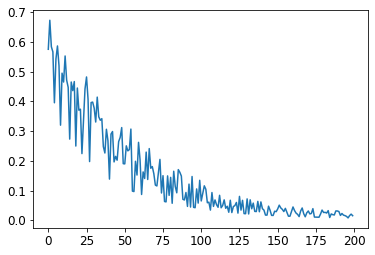

In [7]:
# train decoder
eta = 3e-4

# regularizer/sparsity parameters
beta_reg = 0.0
rho = 2e-2

optimizer = torch.optim.Adam(CN_Z.parameters(),lr=eta)

#lossfun = cross_entr
lossfun = torch.nn.BCELoss()
n_ep = 200
loss_hist = torch.zeros((n_ep,))

# add dynamics
layers = []
for child in CN_Z.module.children():
    layers.append(child)


for ep in torch.arange(0,n_ep):

    shuff_idx = torch.randperm(data_train.shape[0])
    
    for si in shuff_idx:
        
        if beta_reg:        
            rho_hat = torch.zeros((size_hid),).to(DEVICE)

            for H in data_train:

                for lay in layers[:-2]:
                    H = lay(H)

                rho_hat += CN_Z.module.fc(H)

            rho_hat /= data_train.shape[0]

            # regularizer term added to loss
            regu_loss = torch.sum(rho*torch.log(rho/rho_hat) + (1-rho)*torch.log((1-rho)/(1-rho_hat)))
            
            # regularizer added to gradient of bias
            regu_bias = (-rho/rho_hat + ((1-rho)/(1-rho_hat)))
            
        else:
            # if no regularization, just add zero
            regu_loss = torch.zeros(1)

        y = CN_Z(data_train[si])
        optimizer.zero_grad()
        loss = lossfun(y,output_train[si]) + (beta_reg*regu_loss).to(DEVICE)
        
        if beta_reg:
            CN_Z.module.fc.linear.bias.grad += (beta_reg*regu_bias)
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # sparsity penalty -> increase bias
        #print(optimizer.param_groups[0]['lr'])
    loss_hist[ep] = loss

plt.plot(loss_hist.detach().numpy() )

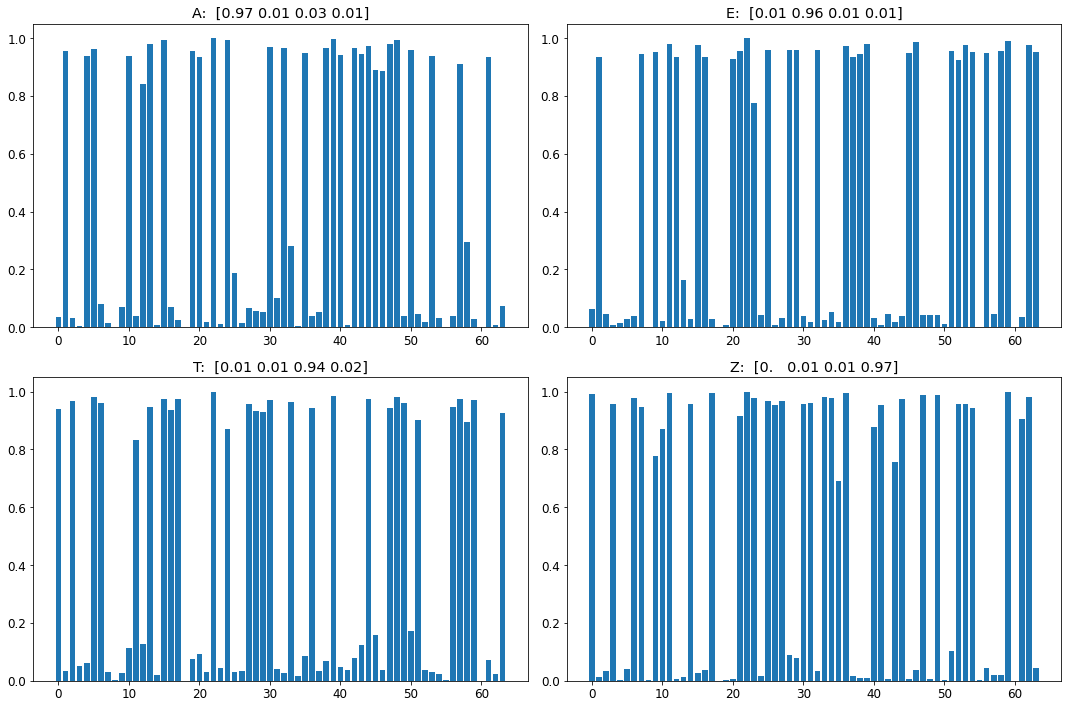

In [8]:
plt.rcParams["figure.figsize"] = (15,10)

label = ['A','E','T','Z']
idx = torch.arange(0,13,4)

hid_acti = torch.zeros((size_hid,4))
for i in torch.arange(0,13,4):
    H = data_train[i]
    for lay in layers[:-1]:
        H = lay(H)
    
    hid_acti[:,int(i/4)] = H

fig, axs = plt.subplots(2,2)
axs = axs.ravel()

for i,ax in enumerate(axs):
    ax.bar(torch.arange(hid_acti.shape[0]),hid_acti[:,i].detach().numpy())
    ax.set_title(label[i] + ':  ' + str((CN_Z(data_train[idx[i]]).cpu().detach().numpy().round(2))))
    
fig.tight_layout()

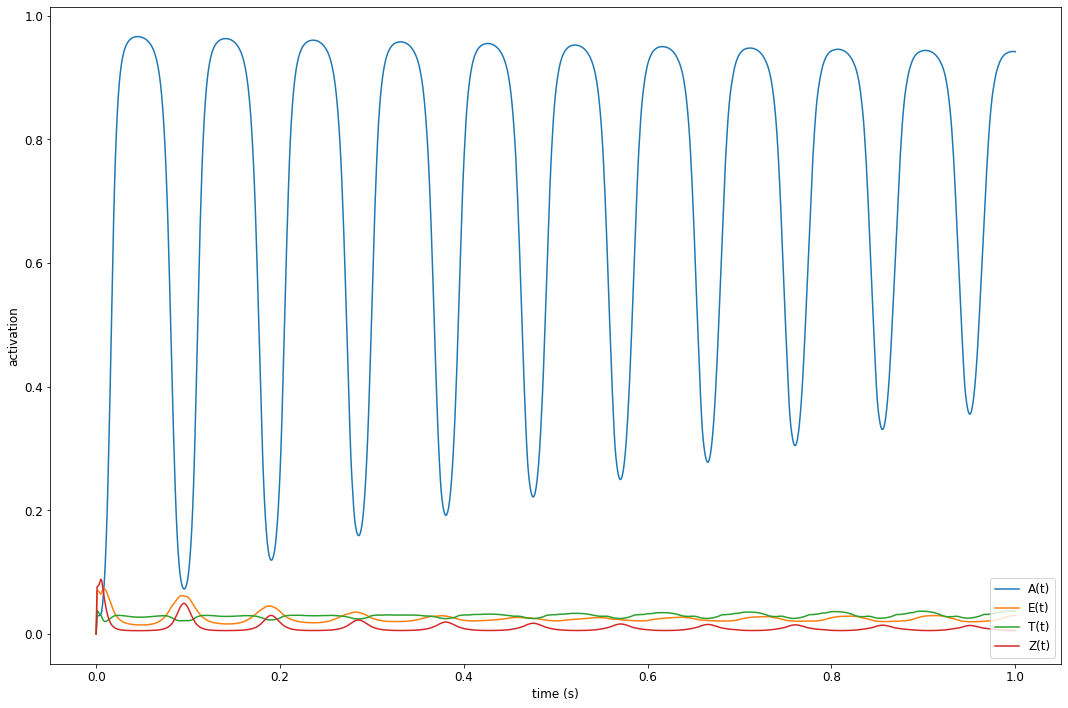

In [9]:
# add dynamics to V1 layer

# one input
H = CN_Z.module.V1.conv(data_train[0])

# V1 and V2: range that values can oscillate in
V1 = 0.0;

V2 = H

beta = 0.001
# # beta: how much adaptation is needed to cause a jump in V
# beta_1 = 1e-2#*I_H#/(2*V2)#*np.sign(V2)
# beta_2_all = torch.arange(0,2e-1,5e-3)

   
# time constants
dt = 0.001
tmax = 3
t_vec = torch.linspace(0,1,int(1/dt))

tau_v = 0.0015#*I_H#(5/V2) # very short time constant for V: determines rate of upswing and reset of membrane potential during a spike
tau_w = 0.15#*I_H#0.01*I_H#(5/V2)  # very long time constant for w: determines rate of recovery betweekn spikes and spike-width

# V0: level above which adaption becomes positive
V0 = V2/2#V2/adap_pos_ratio


I_app = 1e-10#sigmoid(0,sigm_param) # applied current caused in absence of spike change

V = torch.zeros_like(H).to(DEVICE)
w = torch.zeros_like(H).to(DEVICE)
O = torch.zeros((4,t_vec.shape[0])).to(DEVICE)

lay_end = layers[-1]

for i,t in enumerate(t_vec[1:]):

    V += dt*(-beta*V*(V-V1)*(V-V2)-w+0)/tau_v
    w += dt*(V-V0-w)/tau_w

    O[:,i+1] = ffwd(V)

fig, axs = plt.subplots()
#axs[0].plot(t_vec,V.T.cpu().detach().numpy());
axs.plot(t_vec,O.T.cpu().detach().numpy());
axs.legend(('A(t)', 'E(t)', 'T(t)', 'Z(t)'),loc='lower right')
axs.set_xlabel('time (s)')
axs.set_ylabel('activation')

fig.tight_layout()    

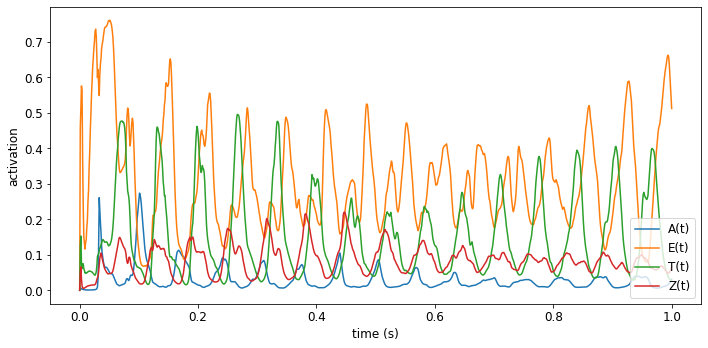

In [10]:

# competing inputs

I = data_train[5]*0.9 + data_train[9]*1.1

H = CN_Z.module.V1.conv(I)

# V1 and V2: range that values can oscillate in
V1 = 0.0;

V2 = H

beta = 0.001
# # beta: how much adaptation is needed to cause a jump in V
# beta_1 = 1e-2#*I_H#/(2*V2)#*np.sign(V2)
# beta_2_all = torch.arange(0,2e-1,5e-3)

1
# time constants
dt = 0.001
tmax = 3
t_vec = torch.linspace(0,1,int(1/dt))

tau_v = 0.001#*I_H#(5/V2) # very short time constant for V: determines rate of upswing and reset of membrane potential during a spike
tau_w = 0.1#*I_H#0.01*I_H#(5/V2)  # very long time constant for w: determines rate of recovery betweekn spikes and spike-width

# V0: level above which adaption becomes positive
V0 = V2/2#V2/adap_pos_ratio


I_app = H#0.02#sigmoid(0,sigm_param) # applied current caused in absence of spike change

V = torch.zeros_like(H).to(DEVICE)
w = torch.zeros_like(H).to(DEVICE)
O = torch.zeros((4,t_vec.shape[0])).to(DEVICE)

lay_end = layers[-1]

for i,t in enumerate(t_vec[1:]):

    V += dt*(-beta*V*(V-V1)*(V-V2)-w+I_app)/tau_v
    w += dt*(V-V0-w+I_app)/tau_w

    O[:,i+1] = ffwd(V)

fig, ax = plt.subplots(1,figsize=(10,5))
#axs[0].plot(t_vec,V.T.cpu().detach().numpy());
ax.plot(t_vec,O.T.cpu().detach().numpy());
ax.legend(('A(t)', 'E(t)', 'T(t)', 'Z(t)'),loc='lower right')
ax.set_xlabel('time (s)')
ax.set_ylabel('activation')
fig.tight_layout()    

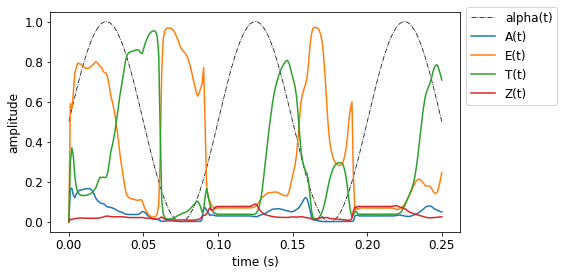

In [11]:
# add dynamics to V1 layer + ALPHA

I = data_train[4]*0.5 + data_train[11]*1.5

H = CN_Z.module.V1.conv(I)

# V1 and V2: range that values can oscillate in
V1 = 0.0;

V2 = H

beta = 0.001
# # beta: how much adaptation is needed to cause a jump in V
# beta_1 = 1e-2#*I_H#/(2*V2)#*np.sign(V2)
# beta_2_all = torch.arange(0,2e-1,5e-3)

   
# time constants
dt = 0.001
tmax = 3
t_vec = torch.linspace(0,0.25,int(0.25/dt))

tau_v = 0.001#*I_H#(5/V2) # very short time constant for V: determines rate of upswing and reset of membrane potential during a spike
tau_w = 0.1#*I_H#0.01*I_H#(5/V2)  # very long time constant for w: determines rate of recovery betweekn spikes and spike-width

# V0: level above which adaption becomes positive
V0 = V2/2#V2/adap_pos_ratio


I_app = H#sigmoid(0,sigm_param) # applied current caused in absence of spike change

V = torch.zeros_like(H).to(DEVICE)
w = torch.zeros_like(H).to(DEVICE)
w[0] = 0.5
O = torch.zeros((4,t_vec.shape[0])).to(DEVICE)

lay_end = layers[-1]

aa = 0.6#torch.max(H).cpu().detach().numpy()/10
alpha_inh = aa*torch.sin(2*torch.pi*10*t_vec)+aa
alpha_plot =0.5*torch.sin(2*torch.pi*10*t_vec)+0.5
for i,t in enumerate(t_vec[1:]):

    V += dt*(-beta*V*(V-V1)*(V-V2)-w+I_app-alpha_inh[i])/tau_v
    w += dt*(V-V0-w+I_app)/tau_w

    O[:,i+1] = ffwd(V)

fig, axs = plt.subplots(figsize=(8,4))
#axs[0].plot(t_vec,V.T.cpu().detach().numpy())
axs.plot(t_vec,alpha_plot,color='k',linestyle='-.',linewidth=.75);
axs.plot(t_vec,O.T.cpu().detach().numpy(),linewidth = 1.5);
axs.legend(('alpha(t)','A(t)', 'E(t)', 'T(t)', 'Z(t)'),bbox_to_anchor=(1., 1.05))
axs.set_xlabel('time (s)')
axs.set_ylabel('amplitude')

fig.tight_layout()    

In [12]:

# Tangledness of representations
import itertools

combi = list(itertools.combinations(torch.arange(0,16,5),2))
combi

all_angle_sum = torch.zeros(len(combi))

for i,c in enumerate(combi):
    
    H1 = data_train[c[0]]
    H2 = data_train[c[1]]
    H3 = data_train[c[0]]+data_train[c[1]]
    
    for li,lay in enumerate(layers[:-1]):

        # apply layer
        H1 = lay(H1)
        H2 = lay(H2)
        H3 = lay(H3)
        
    H1_2 = H1+H2


    num_ = torch.matmul(H3,H1_2)
    denom_ = torch.linalg.vector_norm(H3)*torch.linalg.vector_norm(H1_2)
    all_angle_sum[i] = (torch.acos(num_/denom_)*180/torch.pi).cpu().detach()